In [4]:
import requests
import pandas as pd
import json
from bs4 import BeautifulSoup 
import numpy as np 
import pandas as pd 
import matplotlib 
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bradleybeck/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bradleybeck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
NF = pd.read_csv('/Users/bradleybeck/Documents/MDA 720/Capstone/netflix_titles.csv.zip')
NF.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [6]:
NF.shape[0]

8807

In [7]:
NF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [8]:
print('Columns with missing value:') 
print(NF.isnull().any())

Columns with missing value:
show_id         False
type            False
title           False
director         True
cast             True
country          True
date_added       True
release_year    False
rating           True
duration         True
listed_in       False
description     False
dtype: bool


In [9]:
NF.director.fillna('No Director', inplace = True) 
NF.cast.fillna('No Cast', inplace = True) 
NF.country.fillna('Country Unavailable', inplace = True)
NF.duration.fillna('No Duration', inplace = True)
NF.dropna(subset=['date_added', 'rating'], inplace = True)
#replaced the NAs in director, cast, country, and duration column
#deleted the NAs in the date added and rating column 

In [10]:
print('Columns with missing value:') 
print(NF.isnull().any())

Columns with missing value:
show_id         False
type            False
title           False
director        False
cast            False
country         False
date_added      False
release_year    False
rating          False
duration        False
listed_in       False
description     False
dtype: bool


<function matplotlib.pyplot.show(close=None, block=None)>

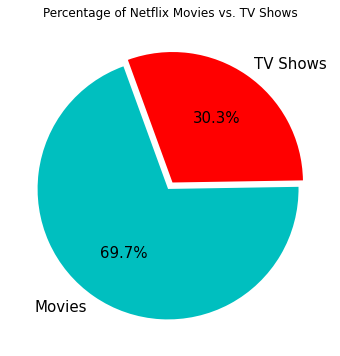

In [11]:
plt.figure(figsize = (12,6)) 
plt.title("Percentage of Netflix Movies vs. TV Shows") 
plt.pie(NF.type.value_counts(), 
            explode = (.03,.03),
            labels = ['Movies', 'TV Shows'], 
            colors = ['c', 'r'], 
            autopct = '%1.1f%%', 
            startangle = 110, textprops = {'color': 'black', 'fontsize': 15})
plt.show

#Netflix consists of 30.3% TV Shows and the remainding 69.7% is Movies

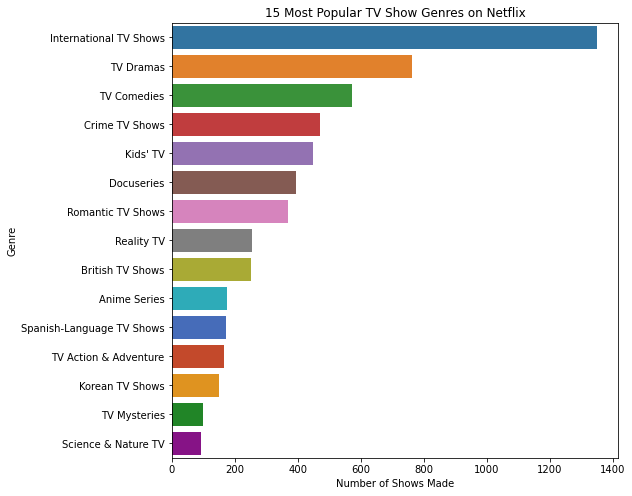

In [12]:
NF_tv = NF[NF['type'] == 'TV Show']

genres = NF_tv.set_index('title').listed_in.str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#3366cc', '#dc3912', '#ff9900', '#109618', '#990099']

plt.figure(figsize = (8,8))
g = sns.countplot(y = genres, 
                  order = genres.value_counts().index[:15],
                 palette = colors)
plt.title('15 Most Popular TV Show Genres on Netflix')
plt.xlabel('Number of Shows Made')
plt.ylabel('Genre')
plt.show()
#Demonstrates the 15 most popular TV Show genres on Netflix by looking at the number of shows made under each genre 

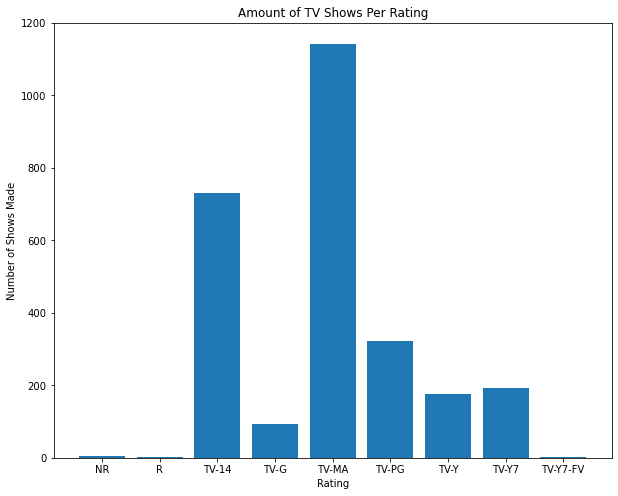

In [13]:
NF_tv = NF[NF['type'] == 'TV Show']

order = NF_tv.rating.unique() 
count_shows = NF_tv.groupby('rating')['title'].count().reset_index() 
count_shows.sort_values(by = "rating", ascending=True) 

plt.figure(figsize = (10,8)) 
plt.title('Amount of TV Shows Per Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Shows Made')
plt.bar(count_shows.rating, count_shows.title) 
plt.show()
# The majority of tv shows created are rated as TV-MA

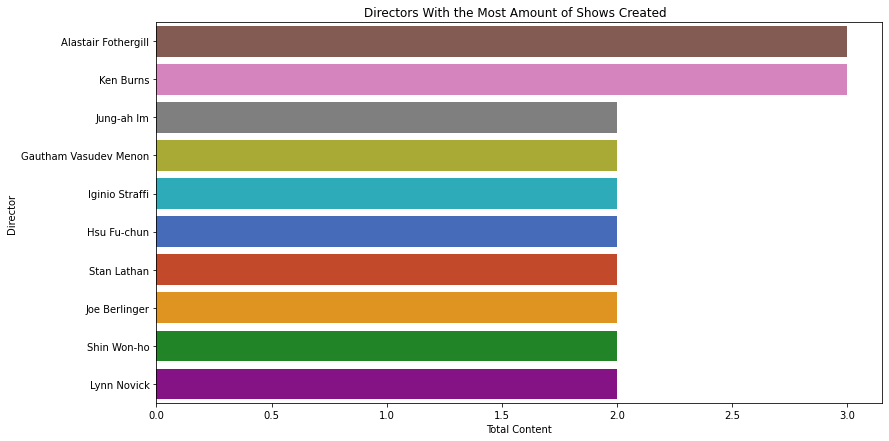

In [14]:
NF_tv = NF[NF['type'] == 'TV Show']

colors = ['#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#3366cc', '#dc3912', '#ff9900', '#109618', '#990099']
filtered_directors = NF_tv[NF_tv.director != 'No Director'].set_index('title').director.str.split(', ', expand=True).stack().reset_index(level=1, drop=True) 
plt.figure(figsize = (13,7)) 
plt.title('Directors With the Most Amount of Shows Created  ') 
sns.countplot(y = filtered_directors, 
              order = filtered_directors.value_counts().index[:10],
             palette = colors) 
plt.xlabel('Total Content')
plt.ylabel('Director')
plt.show()
#Directors and the number of shows they have produced 

Text(0.5, 1.0, 'Number of Shows Released Yearly')

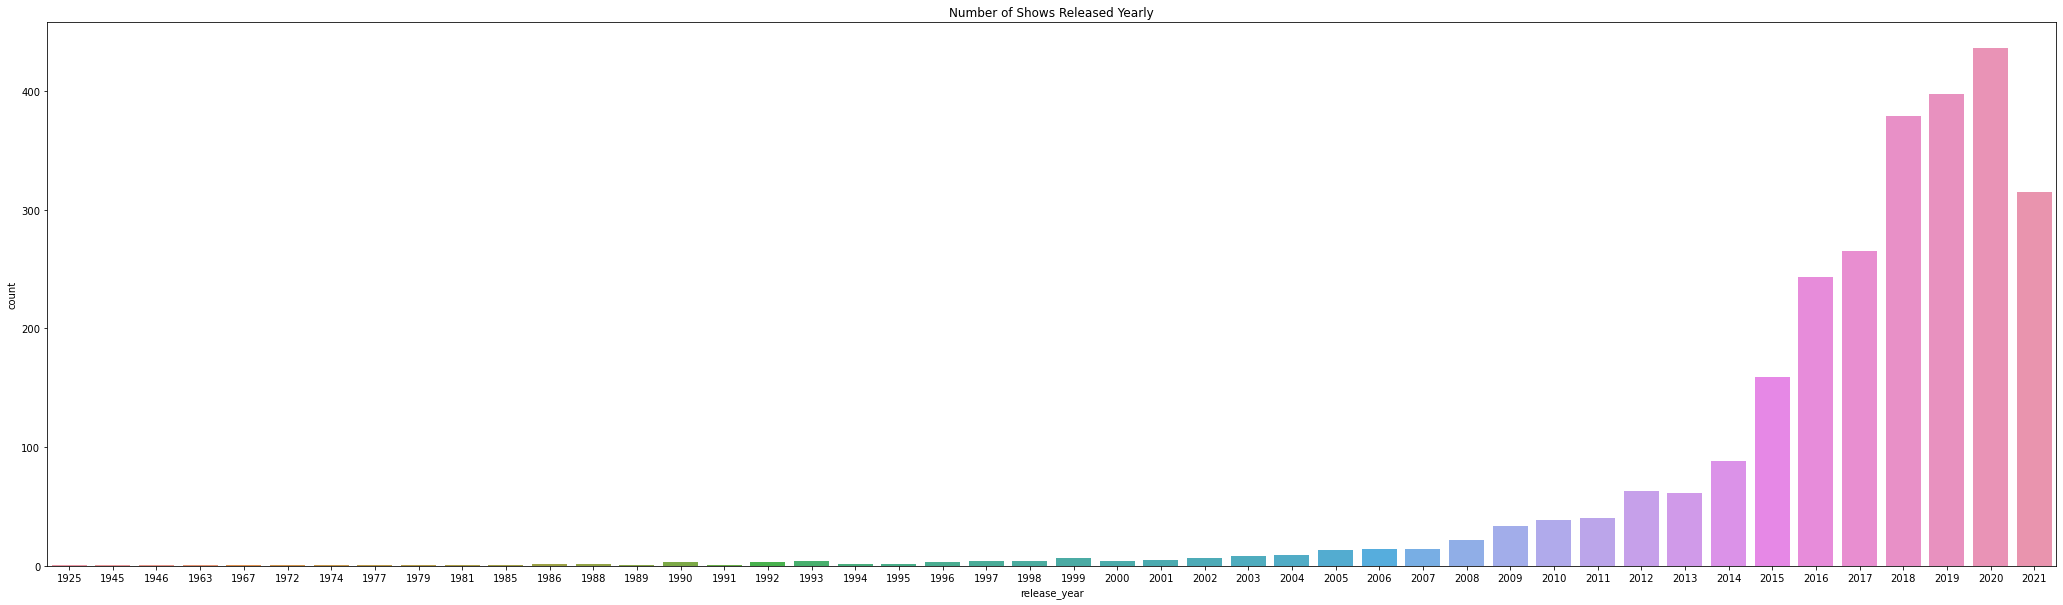

In [33]:
NF_tv = NF[NF['type'] == 'TV Show']
plt.figure(figsize = (36,10))
sns.countplot(x='release_year',data = NF_tv)
plt.title('Number of Shows Released Yearly')
#This graph displays the amount of tv shows that were released each year 

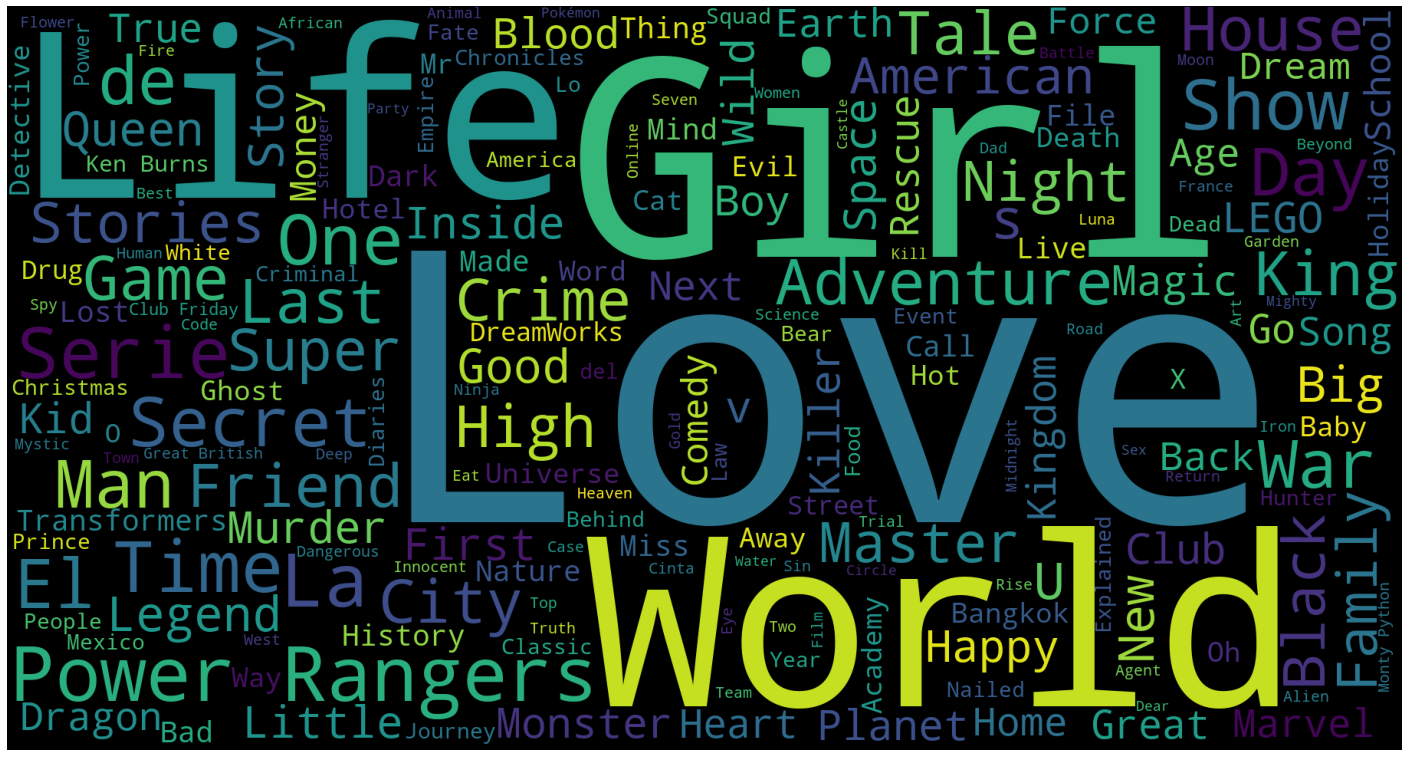

In [35]:
NF_tv = NF[NF['type'] == 'TV Show']
plt.subplots(figsize=(25,15))
wordcloud = WordCloud(
                          background_color='Black',
                          width=1820,
                          height=970
                         ).generate(" ".join(NF_tv.title))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('cast.png')
plt.show()
#Most common words seen in TV Show titles on Netflix

# Sentiment Analysis

In [17]:
NF_tv = NF[NF['type'] == 'TV Show']

df = NF_tv[['release_year','description']]

def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        return "Positive"
    elif sentiment < 0:
        return "Negative"
    else:
        return "Neutral"

df["Sentiment"] = df["description"].apply(get_sentiment)
print(df[["release_year", "description", "Sentiment"]].head(20))
#shows positive, negative, or nuetral tv show descriptions

    release_year                                        description Sentiment
1           2021  After crossing paths at a party, a Cape Town t...   Neutral
2           2021  To protect his family from a powerful drug lor...  Negative
3           2021  Feuds, flirtations and toilet talk go down amo...  Negative
4           2021  In a city of coaching centers known to train I...   Neutral
5           2021  The arrival of a charismatic young priest brin...   Neutral
8           2021  A talented batch of amateur bakers face off in...  Positive
10          2021  Sicily boasts a bold "Anti-Mafia" coalition. B...  Positive
11          2021  Struggling to earn a living in Bangkok, a man ...   Neutral
14          2021  Cameras following Bengaluru police on the job ...  Positive
15          2021  Students of color navigate the daily slights a...  Negative
17          2020  Strangers Diego and Isabel flee their home in ...  Positive
19          2021  In the 1960s, a Holocaust survivor joins a gro

In [18]:
df['sentiment'] = df['description'].apply(get_sentiment)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['description'], 
                                                    df['Sentiment'], 
                                                    test_size=0.3, 
                                                    random_state=42)

In [20]:
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [21]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [22]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.66375


In [32]:
NF_tv['description'].value_counts()

As a psychology professor faces Alzheimer's, his daughter and her three close female friends experience romance, marriage, heartbreak and tragedy.        2
This educational series for tiny tots features a toe-tapping spin on nursery rhymes with upbeat tunes and a diverse set of easy-to-follow lessons.        2
Two quirky cats, Ollie and Moon, and their friend Stanley the snail travel the world, solving everyday problems and learning about different cultures.    2
Born into a small town controlled by the mafia, an irate young woman seeks revenge on the forces that tore apart and wrongfully imprisoned her family.    2
After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth.       1
                                                                                                                                                         ..
Researchers add context and clarity to UFO mysteries and conspir